# MLB Project - Batting & Pitching Analysis

This Notebook is an example, largely borrowed from several online tutorials, of how Machine Learning and Python coded statistical analysis can be used to predict outcomes in sports. These examples are merely templates produced to demonstrate beginner proficiency in computer programming.

First, import the necessary packages:

In [3]:
import os
import pandas as pd
import numpy as np
from pybaseball import batting_stats
from pybaseball import statcast
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Now, create your time filter for batting data. The 'batting_stats' from pybaseball are not unreasonably large, so using a twenty (20) year time frame is not a computational burden.

In [4]:
start = 2002
end = 2022

Next, download the data to a csv file. This notebook assumes you have done so, and will simply read from an already downloaded file. Let's take a look at what statistics are available, and the relative size of the dataframe. Note the descriptions can be found here: https://baseballsavant.mlb.com/csv-docs 

In [6]:
df = pd.read_csv('batting.csv')

print(df.shape)
print(list(df),end == '')

(6449, 320)
['IDfg', 'Season', 'Name', 'Team', 'Age', 'G', 'AB', 'PA', 'H', '1B', '2B', '3B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH', 'GDP', 'SB', 'CS', 'AVG', 'GB', 'FB', 'LD', 'IFFB', 'Pitches', 'Balls', 'Strikes', 'IFH', 'BU', 'BUH', 'BB%', 'K%', 'BB/K', 'OBP', 'SLG', 'OPS', 'ISO', 'BABIP', 'GB/FB', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'IFH%', 'BUH%', 'wOBA', 'wRAA', 'wRC', 'Bat', 'Fld', 'Rep', 'Pos', 'RAR', 'WAR', 'Dol', 'Spd', 'wRC+', 'WPA', '#NAME?', '#NAME?.1', 'RE24', 'REW', 'pLI', 'phLI', 'PH', 'WPA/LI', 'Clutch', 'FB% (Pitch)', 'FBv', 'SL%', 'SLv', 'CT%', 'CTv', 'CB%', 'CBv', 'CH%', 'CHv', 'SF%', 'SFv', 'KN%', 'KNv', 'XX%', 'PO%', 'wFB', 'wSL', 'wCT', 'wCB', 'wCH', 'wSF', 'wKN', 'wFB/C', 'wSL/C', 'wCT/C', 'wCB/C', 'wCH/C', 'wSF/C', 'wKN/C', 'O-Swing%', 'Z-Swing%', 'Swing%', 'O-Contact%', 'Z-Contact%', 'Contact%', 'Zone%', 'F-Strike%', 'SwStr%', 'BsR', 'FA% (sc)', 'FT% (sc)', 'FC% (sc)', 'FS% (sc)', 'FO% (sc)', 'SI% (sc)', 'SL% (sc)', 'CU% (sc)', 'KC% (sc)', 

The 'IDfg' column is a unique identifier for each individual player. We should filter to make sure we are only including those players with at least two seasons.

In [34]:
batting = df.groupby('IDfg', group_keys = False).filter(lambda x: x.shape[0] > 1)

WAR, or 'wins against replacement', is a statistic which measures the individual player's ability to perform better (or worse) than the average replacement player. The higher the WAR, the more undervalued the player, and vice-versa. In order to predict the WAR, and measure the variance against the actual WAR, we need to define a function which brings next season's WAR back one period, given that this is time series data.

Then let's group by each player's identifier, and take a look at some key columns.

In [35]:
def next_season(player):
    player = player.sort_values('Season')
    player['Next_WAR'] = player['WAR'].shift(-1)
    return(player)

batting = batting.groupby('IDfg', group_keys = False).apply(next_season)

print(batting[['Name', 'Season', 'WAR', 'Next_WAR']])

                 Name  Season  WAR  Next_WAR
3733  Alfredo Amezaga    2006  1.1       2.0
2494  Alfredo Amezaga    2007  2.0       1.2
3574  Alfredo Amezaga    2008  1.2       NaN
1006  Garret Anderson    2002  3.7       5.1
419   Garret Anderson    2003  5.1       0.8
...               ...     ...  ...       ...
4528      Owen Miller    2022  0.6       NaN
5705    Andrew Vaughn    2021 -0.3      -0.5
5864    Andrew Vaughn    2022 -0.5       NaN
4706     Ha-seong Kim    2021  0.5       3.7
1047     Ha-seong Kim    2022  3.7       NaN

[6086 rows x 4 columns]


Now we need to:
    1) Remove all 'NaN' values;
    2) Find out which columns are type = objects for later deletion (can only use int for ML);
    3) Switch the 'team' column fron str to int;
    4) Make a copy for computational efficiency; and
    5) Drop any remaining non-values from our new dataframe.

In [36]:
null_count = batting.isnull().sum()
complete_cols = list(batting.columns[null_count == 0])
batting = batting[complete_cols + ['Next_WAR'].copy()]

print(batting.dtypes[batting.dtypes == 'object'])

Name       object
Team       object
Dol        object
Age Rng    object
dtype: object


In [37]:
del batting['Dol'] 
del batting['Age Rng']

batting['Team'] = batting['Team'].astype('category').cat.codes

batting_full = batting.copy()
batting = batting.dropna()

# Regression model: 

We will seek to find which statistics are most relevant to demonstrate an individual player's ability to affect his WAR. 

We will do so using a ridge regression model, a common method used when highly correlated independent variables exist, as they do in baseball statistics (think OBP, Slugging %, HRs, etc.).

In [38]:
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit

rr = Ridge(alpha = 1) #the alpha parameter goes from 0 --> 1 (I think), and the higher the parameter the greater reduction in overfitting
split = TimeSeriesSplit(n_splits = 3) #three separate buckets, necessary for training time series data
sfs = SequentialFeatureSelector(rr, n_features_to_select = 20, direction = 'forward', cv = split, n_jobs = 4)

removed_columns = ['Next_WAR', 'Name', 'IDfg', 'Season'] #don't want to include what we are trying to optimize ('Next_WAR') or any strings ('Name')
selected_columns = batting.columns[~batting.columns.isin(removed_columns)] #this basically takes all of our columns (batting.columns) and then takes out those we removed

from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()
batting.loc[:, selected_columns] = scalar.fit_transform(batting[selected_columns]) #transforms the regression to levels of 0 --> 1, taking out negative values

print(batting)
print(batting.describe())

       IDfg  Season             Name      Team       Age         G        AB  \
3733      1    2006  Alfredo Amezaga  0.333333  0.346154  0.735043  0.312950   
2494      1    2007  Alfredo Amezaga  0.333333  0.384615  0.743590  0.431655   
1006      2    2002  Garret Anderson  0.000000  0.423077  0.957265  0.859712   
419       2    2003  Garret Anderson  0.000000  0.461538  0.965812  0.859712   
4098      2    2004  Garret Anderson  0.000000  0.500000  0.564103  0.507194   
...     ...     ...              ...       ...       ...       ...       ...   
1986  23667    2021    Wander Franco  0.909091  0.038462  0.205128  0.217626   
4339  24618    2021     Ryan Jeffers  0.545455  0.192308  0.333333  0.192446   
6256  24655    2021      Owen Miller  0.242424  0.192308  0.119658  0.055755   
5705  26197    2021    Andrew Vaughn  0.181818  0.153846  0.692308  0.462230   
4706  27506    2021     Ha-seong Kim  0.757576  0.230769  0.606838  0.192446   

            PA         H        1B  ...

Now we will fit the data, or pick the twenty greatest predictors under our ridge regression, then pass them into an array, put into a list, and define that list as 'predictors'.

In [39]:
sfs.fit(batting[selected_columns], batting['Next_WAR'])
predictors = list(selected_columns[sfs.get_support()])

Since we now have our best predictors, we will train and test our model.

We need to use a minimum of 5 years of data to train, and will step forward one year past five when available. 

We will concatenate and combine values to create a new column for our predictions.

In [40]:
def backtest(data, model, predictors, start = 5, step = 1): #step is important because we want at least 5 years of data to train, adding one year step each time
    all_predictions = []
    years = sorted(batting['Season'].unique())
    for i in range(start, len(years), step):
        current_year = years[i]
        train = data[data['Season'] < current_year]
        test = data[data['Season'] == current_year]
        model.fit(train[predictors], train['Next_WAR'])
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index = test.index)
        combined = pd.concat([test['Next_WAR'], preds], axis = 1) #this concatenation with axis = 1 just adds a separate column for our predictions
        combined.columns = ['actual', 'prediction']
        all_predictions.append(combined)
    return pd.concat(all_predictions) #note the default is to concat with axis = 0, which combines into one vertical dataframe, what we want here as opposed to above

In [41]:
def player_history(df):
    df = df.sort_values('Season')
    df['player_season'] = range(0, df.shape[0])

    df['war_corr'] = list(df[['player_season', 'WAR']].expanding().corr().loc[(slice(None), 'player_season'), 'WAR'])
    df['war_corr'].fillna(1, inplace = True)

    df['war_diff'] = df['WAR'] / df['WAR'].shift(1) #shift(1) brings the previous seasons value up to the current year
    df['war_diff'].fillna(1, inplace = True)
    df['war_diff'][df['war_diff'] == np.inf] = 1 #this replaces any infinite values captured by the line two above and replaces it with one
    return df

batting = batting.groupby('IDfg', group_keys = False).apply(player_history)

def group_averages(df):
    return df['WAR'] / df['WAR'].mean() #this helps to offset against any reduced appearances due to injury, etc.

batting['war_season'] = batting.groupby('Season', group_keys = False).apply(group_averages)

new_predictors = predictors + ['player_season', 'war_corr', 'war_diff', 'war_season']

predictions = backtest(batting, rr, new_predictors)

In typical regression, the Mean Squared Error ("MSE") is a representation of the validity of the regression model. More precisely, if the square root of the MSE is less than the standard deviation of the statistic you are trying to measure (in this case WAR), then your model is valid.

In [42]:
from sklearn.metrics import mean_squared_error

m_sq_err = mean_squared_error(predictions['actual'], predictions['prediction'])
print('\nThe mean squared error is',round(m_sq_err,2),'and its square root is', round(m.sqrt(m_sq_err),2))
print('The standard deviation of the wins above replacement is', round(batting['Next_WAR'].std(),2))
if m.sqrt(m_sq_err) < batting['Next_WAR'].std():
    print('Because the square root of the MSE is less than the standard deviation of the win against replacement statistic, the predictors have proven useful')
else:
    print('Because the square root of the MSE is more than the standard deviation of the win against replacement statistic, the predictors have not proven useful\n')


The mean squared error is 2.81 and its square root is 1.68
The standard deviation of the wins above replacement is 2.02
Because the square root of the MSE is less than the standard deviation of the win against replacement statistic, the predictors have proven useful


# Regression Result

In [43]:
print(pd.Series(rr.coef_, index = new_predictors).sort_values())

Age             -2.897341
BABIP           -2.024284
Off             -1.367021
Soft%+          -1.054941
ISO             -1.007031
WAR             -0.815466
BU              -0.757623
PH              -0.628545
war_diff        -0.559865
SO              -0.527100
SH              -0.406840
CB%             -0.333771
Clutch          -0.288230
CH%             -0.286779
war_corr        -0.114635
player_season    0.003423
BB/K             0.148364
Spd              0.801952
Oppo%            0.812315
SB               1.034518
OBP              1.368524
IBB              1.499462
Hard%+           2.224188
war_season       3.215245
dtype: float64


Above we see which statistics are most useful in predicting a player's WAR. Those at the extreme ends (positive and negative) have the highest effect on predicting WAR, and those in the middle are less effective.

So don't sign old players, but this is only for baseball, you should hire me.

In [44]:
diff = predictions['actual'] - predictions['prediction']
merged = predictions.merge(batting, left_index = True, right_index = True)
merged['diff'] = (predictions['actual'] - predictions['prediction']).abs()
print(merged[['IDfg', 'Season', 'Name', 'WAR', 'Next_WAR', 'diff']].sort_values(['diff']))

       IDfg  Season               Name       WAR  Next_WAR      diff
2914   1907    2015      Andres Blanco  0.310559       0.0  0.001554
3620   3441    2009      Nolan Reimold  0.279503       1.3  0.003125
55    12916    2018   Francisco Lindor  0.695652       5.8  0.003175
1327   8252    2009       Hunter Pence  0.409938       2.7  0.003546
5538  10472    2016  Enrique Hernandez  0.204969       1.1  0.004120
...     ...     ...                ...       ...       ...       ...
5294   5631    2010          Matt Kemp  0.211180       8.3  6.333965
3383   1875    2009      Josh Hamilton  0.291925       8.4  6.373255
833    9166    2010       Buster Posey  0.459627      10.1  6.639403
2973  11579    2014       Bryce Harper  0.310559       9.3  7.462984
316   15640    2021        Aaron Judge  0.552795      11.5  7.718713

[3658 rows x 6 columns]


Finally we create a new dataframe which measures the difference between the actual and predicted WAR, measuring those players who performed very well versus expectations (high diff), and those that performed as expected (low diff).

# Pitching Visualizations

Just a few scatterplots to look from Statcast data to visualize how pitching mechanics affect outcomes.

First get data from Statcast. Note in contrast to hitting data, Statcast files can be large, so limit your date range accordingly and shape data to remove unnecessary columns, NaN values, etc.

This sheet has already been retrieved, shaped and saved.

In [45]:
import pandas as pd

df_2 = pd.read_excel('pitch_stuff.xlsb')

First let's look at effective speed.

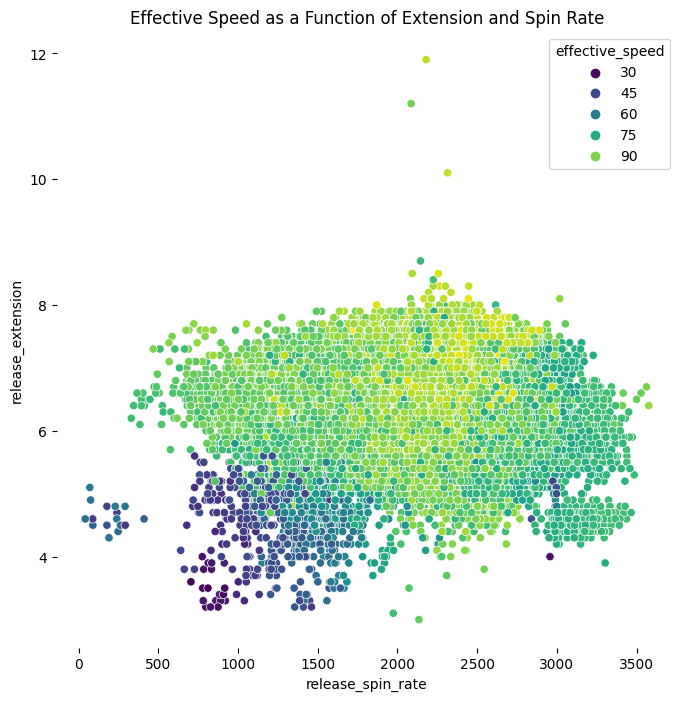

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

df_3 = df_2.dropna(subset = ['release_spin_rate', 'release_extension', 'effective_speed'])
fig, ax = plt.subplots(figsize = (8, 8))
sns.despine(fig, left = True, bottom = True)
sns.scatterplot(x = 'release_spin_rate', y = 'release_extension',
                hue = 'effective_speed',
                palette = 'viridis',
                data = df_3,
                ax = ax)
ax.set_title('Effective Speed as a Function of Extension and Spin Rate')
plt.show()

Possible conclusions:
    1) The higher the extension and spin rate, the higher the effective speed.
    2) Sidearm pitchers do not generate as much velocity or spin.
  
  Now let's look at Release Speed:

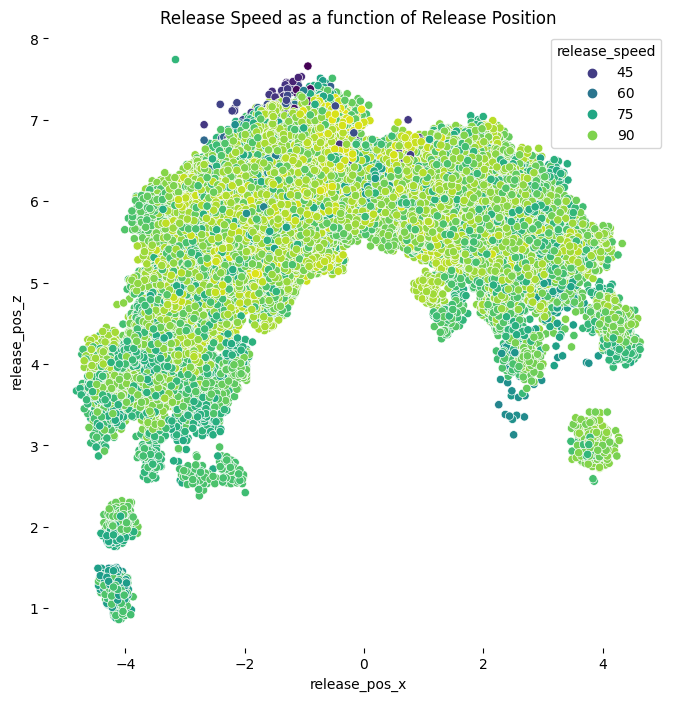

In [47]:
df_3 = df_2.dropna(subset = ['release_speed', 'release_pos_x', 'release_pos_z'])
fig, ax = plt.subplots(figsize = (8, 8))
sns.despine(fig, left = True, bottom = True)
sns.scatterplot(x = 'release_pos_x', y = 'release_pos_z',
                hue = 'release_speed',
                palette = 'viridis',
                data = df_3,
                ax = ax)
ax.set_title('Release Speed as a function of Release Position')
plt.show()

This is a helpful visualization.

From release_pos_x < 0, you see right handed pitchers:
    1) Those with high vertical release_pos_z have lower release_speed.
    2) Those with coordinates ~ (-2,-6) have higher release_speed.
    3) Two disctinct sidearm pitchers can be seen at (-4,-1) & (-4,-2), with average release_speed.
  
From release_pos_x > 0, you see left handed pitchers:
    1) A smaller dataset.
    2) Less release_speed across the board (perhaps).
    3) Only one distinct sidearm pitcher, but he seems to have greater release_speed than his right handed counterpart.

Finally, let's look at how batters fared based on the contact stats:

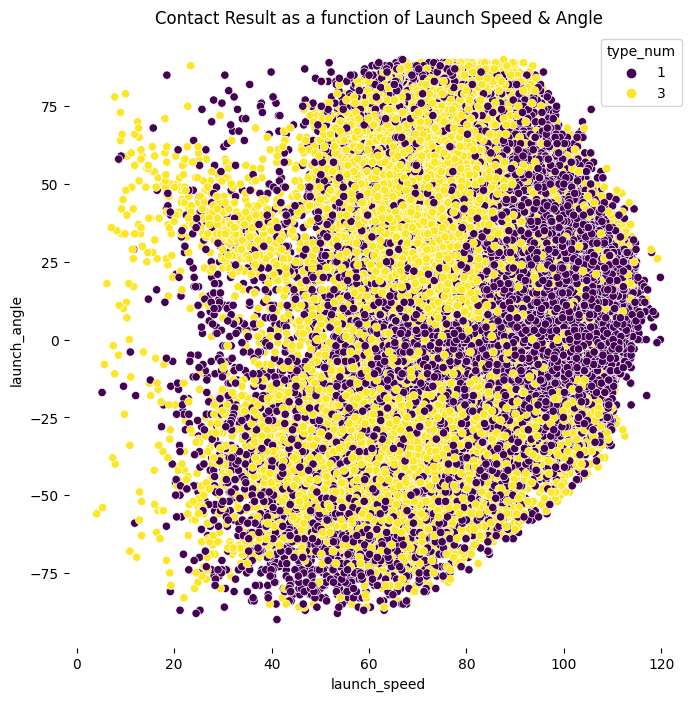

In [48]:
df_3 = df_2.dropna(subset = ['launch_speed', 'launch_angle', 'type_num'])
fig, ax = plt.subplots(figsize = (8, 8))
sns.despine(fig, left = True, bottom = True)
sns.scatterplot(x = 'launch_speed', y = 'launch_angle',
                hue = 'type_num',
                palette = 'viridis',
                data = df_3,
                ax = ax)
ax.set_title('Contact Result as a function of Launch Speed & Angle')
plt.show()

In the legend, type_num(1) = hits, type_num(3) = outs.

Not surprisingly, medium and hard hit line drives appear to get people on base with the greatest frequency. 

Interestingly, dribblers and bunts appear to work as well, i.e. those with launch_speeds from ~30-60, and launch_angle from ~-80--50.

# Conclusion

I'd rather be playing sports than betting on them.